In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.optimize import minimize

sns.set(context="talk")

In [2]:
data = loadmat("ex3data1.mat")
X = data["X"]
print("X matrix shape =", data["X"].shape, "\n", X)
y = data["y"]
print("y matrix shape =", data["y"].shape, "\n", y)
num_classes = 10 # 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)

X matrix shape = (5000, 400) 
 [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
y matrix shape = (5000, 1) 
 [[10]
 [10]
 [10]
 ..., 
 [ 9]
 [ 9]
 [ 9]]


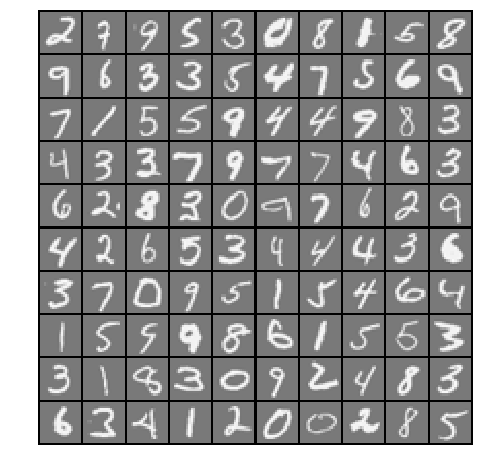

In [3]:
def displayData(X, ex_width=20, figsize=(8, 8)):
    # Compute rows, cols
    m, n = X.shape
    ex_height = n / ex_width
    # Compute number of items to display
    disp_rows = np.floor(np.sqrt(m))
    disp_cols = np.ceil(m/disp_rows)
    # Between images padding
    pad = 1
    # Setup blank display
    disp_array = -np.ones((int(pad + disp_rows*(ex_height + pad)), int(pad + disp_cols*(ex_width + pad))))
    curr_ex = 0
    for i in range(int(disp_rows)):
        for j in range(int(disp_cols)):
            if curr_ex == m:
                break
            max_val = np.max(np.abs((X[0,:])))
            disp_array[int(pad + i*(ex_height+pad)): int(pad + i*(ex_height+pad) + ex_height), \
                       int(pad + j*(ex_width+pad)): int(pad + j*(ex_width+pad) + ex_width)] \
            = X[curr_ex, :].reshape(int(ex_width), int(ex_height)).T
            curr_ex = curr_ex + 1
        if curr_ex == m:
            break
    plt.figure(figsize=figsize)
    plt.imshow(disp_array, cmap="gray")
    plt.axis("off")
    plt.show()
    
# Randomly select 100 data points to display
ramdom_indices = np.random.choice(range(5000), 100)
sample = X[ramdom_indices, :]
displayData(sample)

#### Define hypothesis and cost function

In [4]:
# Logistic regression function
def hypo(theta, X):
    h = 1 / (1 + np.exp(-X.dot(theta)))
    return h.reshape((-1, 1))

# Cost function
def costFun(theta, X, y, lamb=0):
    m = len(y)
    h = hypo(theta, X)
    return 1/m * np.sum(-y*np.log(h) - (1-y)*np.log(1-h)) + lamb/(2*m) * np.sum(theta[1:]**2)

# Gradient function
def gradient(theta, X, y, lamb=0):
    m = len(y)
    h = hypo(theta, X)
    gradient = 1/m * (h - y).T.dot(X).T
    gradient[1:, 0] = gradient[1:, 0] + (lamb/m*theta[1:])
    return gradient.ravel()

#### Test case for Cost Function and Gradient Function with regularization

In [5]:
theta_t = np.array([-2, -1, 1, 2])
X_t = np.array([[1, 0.1, 0.6, 1.1], [1, 0.2, 0.7, 1.2], [1, 0.3, 0.8, 1.3], [1, 0.4, 0.9, 1.4], [1, 0.5, 1.0, 1.5]])
y_t = np.array([[1, 0, 1, 0, 1]]).T
lambda_t = 3
print("Cost: ", costFun(theta_t, X_t, y_t, lamb=lambda_t))
print("Expected cost: 2.534819\n")
print("Gradient: ", gradient(theta_t, X_t, y_t, lamb=lambda_t))
print("Expected gradients: [0.146561  -0.548558  0.724722  1.398003]")

Cost:  2.53481939611
Expected cost: 2.534819

Gradient:  [ 0.14656137 -0.54855841  0.72472227  1.39800296]
Expected gradients: [0.146561  -0.548558  0.724722  1.398003]


#### One-vs-All Training

In [6]:
def oneVsAll(X, y, num_classes, lamb):
    m, n = X.shape
    X = np.concatenate((np.ones((m, 1)), X), axis=1)
    theta = np.zeros([X.shape[1]])
    all_theta = np.zeros((num_classes, n+1))
    for i in range(num_classes):
        res = minimize(costFun, theta, args=(X, np.array((y%10)==i, dtype=int), lamb), jac=gradient, method="TNC")
        print("Class", i, "training:", "Success." if res.success else "Failed.", res.message)
        all_theta[i, :] = res.x
    return all_theta

lamb = 0.1
all_theta = oneVsAll(X, y, num_classes, lamb)

Class 0 training: Success. Converged (|f_n-f_(n-1)| ~= 0)
Class 1 training: Success. Converged (|f_n-f_(n-1)| ~= 0)
Class 2 training: Success. Converged (|f_n-f_(n-1)| ~= 0)
Class 3 training: Success. Converged (|f_n-f_(n-1)| ~= 0)
Class 4 training: Success. Converged (|f_n-f_(n-1)| ~= 0)
Class 5 training: Success. Converged (|f_n-f_(n-1)| ~= 0)
Class 6 training: Success. Converged (|f_n-f_(n-1)| ~= 0)
Class 7 training: Success. Converged (|f_n-f_(n-1)| ~= 0)
Class 8 training: Success. Converged (|f_n-f_(n-1)| ~= 0)
Class 9 training: Success. Converged (|f_n-f_(n-1)| ~= 0)


#### Predict for One-vs-All

In [7]:
def predictOneVsAll(all_theta, X):
    m, n = X.shape
    num_classes = all_theta.shape[0]
    X = np.concatenate((np.ones((m, 1)), X), axis=1)
    for i in range(num_classes):
        p = np.argmax(X.dot(all_theta.T), axis=1)
    return p.reshape(-1, 1)

p = predictOneVsAll(all_theta, X)
acc = np.mean(np.array(p==(y%10), dtype=float))
print("Training Set Accuracy: {0:.2f}%".format(acc*100))

Training Set Accuracy: 96.46%
